<a href="https://colab.research.google.com/github/alexfok/IntroDeepLearning2022/blob/main/IDL_Project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alexander Fok 308669944

Avi Dvir 204423735

Gal Cohen 204675805

# **Title: Unsupervised Deep Embedding for Clustering Analysis**

**Project Supervisor**: May Malka.


# **Introduction**
In this project, we build a Unsupervised Deep Embedding for Clustering Analysis with AE, etc 


# **Implementation** - Environment

### Environment Initialization

### Imports


In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile


# Install dependencies
%pip install wget torch torchvision imageio
import wget

# Imports for MNIST loading
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import datasets, transforms

# Imports for STL10 loading
import sys
import os, sys, tarfile, errno
import random


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=11698440015538bdd1a73b4476a53fbcbf0739a0f338ce0a00867f6ca8b2e544
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


### Control Variables and Initialization

In [2]:
# Notebook Control variables
DEBUG_STL10 = False
# Print DEBUG info
DEBUG = False
# Variable controlling debug prints while training\infering with NN
DEBUG_NN = False
# Train
TRAIN = True
# Create the data sets or load the preloaded np arrays
CREATE_DATA = True
# Path to save the created numpy arrays
array_save_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/data.npy'
# Path to load the created numpy arrays
array_load_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/data.npy.npz'
#best_model_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/project/model_chkpt_epoch_20.pk'
#checkpoint_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/project/model_chkpt_epoch_{}.pk'
#model_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project_model2.pk'
model_path_stl10 = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/project_model2_stl10.pk'
model_path_mnist = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/project_model2_mnist.pk'
# Raw data set paths
path_train = "/content/gdrive/My Drive/IntroDeepLearning2022Data/project"
#path_train = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/train/*.*"
#path_test_m = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_m/*.*"
#path_test_w = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_w/*.*"
# Set random seeds

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'CPU\GPI device: {dev}')

torch.manual_seed(1)
torch.cuda.manual_seed(1)

CPU\GPI device: cuda


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

### Helper Functions


In [3]:
# Function to count number of model parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

# Function to display images
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(15, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N], cmap='Greys_r')
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(15, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N], cmap='Greys_r')
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

# Dataset

### Data Load and Exploration
## Data Statistics

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

MNIST Data
- number of images in training set: 60000
- number of images in test set: 10000
- image shape: $(28, 28)$.
- 10 image classes: ``0,1,2,3,4,5,6,7,8,9``
- We resize the images to $(32, 32)$, to allow the usage of the same NN architecture, that assumes image shapes of $(H/2^4, W/2^4)$.

STL10 Data
- stl10_binary.tar.gz size: 2.5 gb
- number of images in training set: 5000
- number of images in test set: 8000
- image shape: $(96, 96, 3)$.
- 10 image classes: 
 `` airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck``
- Due to lack of RAM, we didn't use unlabeled images dataset - 100000 images.

## Load MNIST dataset
We direclty load the images by batches. Note that we keep the division of the data into training and test sets to get some sense on how the variational autoencoder adapts during the trainig procedure. Nonetheless, there are no lables used here as this is unsupervised learning.

In [4]:
#mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
#mnist_data = list(mnist_data)[:4096]

#batch_size = 256
 
#train_loader = torch.utils.data.DataLoader(
#    MNIST('./data', train=True, download=True,
#                   transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(
#    MNIST('./data', train=False, transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)

#mnist_data = train_loader.dataset.detach().numpy()
#mnist_data = train_loader.dataset
#mnist_data = next(iter(train_loader))[0].numpy()
def create_mnist_dataset():
    print(f'Creating MNIST dataset')
    norm_mean = 0.5 
    norm_std = 0.5 
#    image_h, image_w = (28, 28)
    image_size = (32, 32)

#    trfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((norm_mean,), (norm_std,))])
#    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Grayscale(3)])
    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
#    trfm = transforms.ToTensor()

    mnist_data = datasets.MNIST('data', train=True, download=True, transform=trfm)
    mnist_data_test = datasets.MNIST('data', train=False, download=True, transform=trfm)
    mnist_data_nparray = mnist_data.data.numpy()
    print(f'type(mnist_data_nparray): {type(mnist_data_nparray)}')
    print(f'len(mnist_data_nparray): {len(mnist_data_nparray)}')
    print(f'mnist_data.data.shape: {mnist_data.data.shape}')
    print(f'mnist_data_test.data.shape: {mnist_data_test.data.shape}')
    return mnist_data, mnist_data_test

## Load STL dataset
We direclty load the images by batches. Note that we keep the division of the data into training and test sets to get some sense on how the variational autoencoder adapts during the trainig procedure. Nonetheless, there are no lables used here as this is unsupervised learning.

In [5]:
import urllib.request as urllib
from imageio import imsave
print(sys.version_info) 

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'
# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'
# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'
# path to the binary test file with image data
TEST_DATA_PATH = './data/stl10_binary/test_X.bin'
# path to the binary test file with labels
TEST_LABEL_PATH = './data/stl10_binary/test_y.bin'
# path to the binary unlabeled file
UNLABELED_DATA_PATH = './data/stl10_binary/unlabeled_X.bin'
# path to the class names file
CLASS_NAMES_PATH = './data/stl10_binary/class_names.txt'

def read_class_names(path_to_class_names):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_class_names, 'r') as f:
        class_names = f.read()
        class_names_list = class_names.split("\n")
        # remove last empty '\n'
        class_names_list = class_names_list[:-1]
        return class_names_list

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
    else:
        print(f'data set already downloaded: {filepath}')

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1


if DEBUG_STL10:
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk
    save_images(images, labels)

def create_stl10_dataset():
    print(f'Creating STL10 dataset')
    # download data if needed
#    dest_directory = DATA_DIR
#    if not os.path.exists(dest_directory):
    download_and_extract()
    # load train dataset to np array
    train_images = read_all_images(DATA_PATH)
    print(f'train_images.shape: {train_images.shape}')
    train_labels = read_labels(LABEL_PATH)
    print(f'train_labels.shape: {train_labels.shape}')

    # load test dataset to np array
    test_images = read_all_images(TEST_DATA_PATH)
    print(f'test_images.shape: {test_images.shape}')
    test_labels = read_labels(TEST_LABEL_PATH)
    print(f'test_labels.shape: {test_labels.shape}')

    class_names = read_class_names(CLASS_NAMES_PATH)
    print(f'len(class_names): {len(class_names)}')
    

    # load unlabeled dataset to np array
#    unlabeled_images = read_all_images(UNLABELED_DATA_PATH)
#    print(f'unlabeled_images.shape: {unlabeled_images.shape}')
#    return train_images, train_labels, test_images, test_labels, unlabeled_images
    unlabeled_images = np.zeros(10)
    return train_images, train_labels, test_images, test_labels, unlabeled_images, class_names


sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


## Create or Load Datasets

In [6]:
# Save numpy arrays
def save_numpy_arrays(mnist_data_nparray, stl10_data_nparray):
  np.savez(array_save_path, mnist_data_nparray = mnist_data_nparray, stl10_data_nparray = stl10_data_nparray)

# Load numpy arrays
def load_numpy_arrays(array_load_path):
  stl10_data_nparray = None
  mnist_data_nparray = None
  data = np.load(array_load_path, allow_pickle = True)
  stl10_data_nparray = data['stl10_data_nparray']
  mnist_data_nparray = data['mnist_data_nparray']
  if DEBUG:
    print(f'loaded data.files {data.files}')
    print(f'stl10_data_nparray.shape {stl10_data_nparray.shape}')
    print(f'mnist_data_nparray.shape {mnist_data_nparray.shape}')
  return mnist_data_nparray, stl10_data_nparray


# These data sets will be initialized at the end of this cell
#stl10_data_nparray = None
#stl10_labels_nparray = None
#mnist_data_nparray = None
mnist_test_split, mnist_train_split = None, None
stl10_test_split, stl10_train_split = None, None
stl10_labels_test_split, stl10_labels_train_split = None, None
stl10_train_split_unlabeled = None
stl10_class_names = None

#CREATE_DATA = False
#DEBUG = True
if CREATE_DATA:
  # Create and save data sets
#  print('Create numpy arrays from raw data sets and save to GDrive')
  print('Create numpy arrays from raw data sets')
#  stl10_data_nparray, stl10_labels_nparray = create_stl10_dataset()
  stl10_train_split, stl10_labels_train_split, stl10_test_split, stl10_labels_test_split, stl10_train_split_unlabeled, stl10_class_names = create_stl10_dataset()
  mnist_train_split, mnist_test_split = create_mnist_dataset()
  # Do not save data nparrays in GDrive
#  save_numpy_arrays(mnist_data_nparray, stl10_data_nparray)
else:
  print('Load the numpy arrays from GDrive isnot supported')
  # Load the data files and initiate global variables:
  # train_data, test_m_data, test_w_data, valid_set, train_set
  # Verify that data file exists
  # !ls -la $array_load_path
#  mnist_data_nparray, stl10_data_nparray = load_numpy_arrays(array_load_path)

#img1 = mnist_data_nparray[0]
#print(f'img1.shape: {img1.shape}')
#print(f'img1: {img1}')
#plot_image(img1)

#img2 = stl10_data_nparray[0]
#print(f'img2.shape: {img2.shape}')
#print(f'img2: {img2}')
#plot_image(img2)
#label1 = stl10_labels_nparray[1024]
#print(f'label1.shape: {label1.shape} {label1}')
#stl10_data_nparray = None
#stl10_labels_nparray = None
#mnist_data_nparray = None

# Normalize datasets
# Process the loaded data
# Divide data by 255
#mnist_data_nparray = mnist_data_nparray/255.0
stl10_train_split = stl10_train_split/255.0
stl10_test_split = stl10_test_split/255.0
stl10_train_split_unlabeled = stl10_train_split_unlabeled/255.0

#mnist_data_nparray = mnist_data_nparray.astype(np.float32)
stl10_train_split = stl10_train_split.astype(np.float32)
stl10_test_split = stl10_test_split.astype(np.float32)
stl10_train_split_unlabeled = stl10_train_split_unlabeled.astype(np.float32)
# Subtract 0.5
#mnist_data_nparray -= 0.5
#stl10_data_nparray -= 0.5

# Shift STL10 labels from range 1..10 to range 0..9
stl10_labels_train_split = stl10_labels_train_split -1
stl10_labels_test_split = stl10_labels_test_split -1

# debug normalized images
#img1 = mnist_data_nparray[0]
#print(f'img1.shape: {img1.shape}')
#print(f'img1: {img1}')
#plot_image(img1)
#img2 = stl10_data_nparray[0]
#print(f'img2.shape: {img2.shape}')
#print(f'img2: {img2}')
#plot_image(img2)

# Split the train data to train (80%) and test (20%) data sets
def split_data(data_nparray):
  split_idx = int(data_nparray.shape[0]/5)
  print(f'data_nparray.shape: {data_nparray.shape}, split_idx: {split_idx}')
  test_split, train_split = data_nparray[:split_idx], data_nparray[split_idx:]
  print(f'test_split.shape: {test_split.shape}, train_split.shape: {train_split.shape}')
  return test_split, train_split

#mnist_test_split, mnist_train_split = split_data(mnist_data_nparray)
#stl10_test_split, stl10_train_split = split_data(stl10_data_nparray)
#stl10_labels_test_split, stl10_labels_train_split = split_data(stl10_labels_nparray)


Create numpy arrays from raw data sets
Creating STL10 dataset
train_images.shape: (5000, 96, 96, 3)
train_labels.shape: (5000,)
test_images.shape: (8000, 96, 96, 3)
test_labels.shape: (8000,)
len(class_names): 10
Creating MNIST dataset


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

type(mnist_data_nparray): <class 'numpy.ndarray'>
len(mnist_data_nparray): 60000
mnist_data.data.shape: torch.Size([60000, 28, 28])
mnist_data_test.data.shape: torch.Size([10000, 28, 28])


## Check the Dataset Download
Check that dataset downloaded and unpacked properly on local machine (GCP VM in case of running on colab)

In [7]:
!ls $DATA_PATH
!ls -lah  $DATA_DIR/stl10_binary


./data/stl10_binary/train_X.bin
total 3.0G
drwxr-xr-x 2 10176  1000 4.0K Apr  8  2011 .
drwxr-xr-x 4 root  root  4.0K Feb 14 06:47 ..
-rw-r--r-- 1 10176  1000   55 Mar 16  2011 class_names.txt
-rw-r--r-- 1 10176 users  47K Apr  8  2011 fold_indices.txt
-rw-r--r-- 1 10176 users 211M Apr  8  2011 test_X.bin
-rw-r--r-- 1 10176 users 7.9K Apr  8  2011 test_y.bin
-rw-r--r-- 1 10176 users 132M Apr  8  2011 train_X.bin
-rw-r--r-- 1 10176 users 4.9K Apr  8  2011 train_y.bin
-rw-r--r-- 1 10176 users 2.6G Mar 16  2011 unlabeled_X.bin


In [8]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import cv2

'''
  train_loader = torch.utils.data.DataLoader(mnist_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(mnist_test_split, batch_size=batch_size, shuffle=True) 

      for batch_idx, batch in enumerate(train_loader):
#        imgs, _ = batch
        imgs = batch
        imgs = imgs.to(dev)
'''
if __name__ == '__main__':
#    mnist_train = MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Grayscale(3)]))
    mnist_train = MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    first_x = mnist_train.data[0]
    print(f'first_x.shape: {first_x.shape}')  # expect to see [28, 28], actual [28, 28]
    print(f'mnist_train.data.shape:{mnist_train.data.shape}')

    train_loader2 = torch.utils.data.DataLoader(mnist_train, batch_size=200)
    batch_x, batch_y = next(iter(train_loader2))  # get first batch
    print(f'batch_x.shape:{batch_x.shape}')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]
    # Where is the extra dimension of 1 from?
#    print(len(first_x))
#    first_x = cv2.cvtColor(first_x.detach().numpy(), cv2.COLOR_GRAY2RGB)
    print(f'batch_x.shape: {batch_x.shape}')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]
#    print(len(first_x))
#    plt.imshow(first_x)

    image_size = (32, 32)


    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=trfm)
#    mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    first_x = mnist_data.data[0]
    print(f'first_x.shape: {first_x.shape}')  # expect to see [28, 28], actual [28, 28]
    print(f'mnist_data.data.shape:{mnist_data.data.shape}\n\n')

    mnist_data_nparray = mnist_data.data.numpy()
    print(f'mnist_data_nparray.shape:{mnist_data_nparray.shape}')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]
    train_loader1 = torch.utils.data.DataLoader(mnist_data_nparray, batch_size=50, shuffle=True) 
#    batch_x, batch_y = next(iter(train_loader1))  # get first batch
    batch_x = next(iter(train_loader1))  # get first batch
    print(f'batch_x.shape: {batch_x.shape}\n\n')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]


    train_loader11 = torch.utils.data.DataLoader(mnist_data, batch_size=50, shuffle=True) 
    batch_x, batch_y = next(iter(train_loader11))  # get first batch
#    batch_x = next(iter(train_loader1))  # get first batch
    print(f'batch_x.shape: {batch_x.shape}')  # expect to see [200, 28, 28], actual [200, 1, 28, 28]


first_x.shape: torch.Size([28, 28])
mnist_train.data.shape:torch.Size([60000, 28, 28])
batch_x.shape:torch.Size([200, 1, 28, 28])
batch_x.shape: torch.Size([200, 1, 28, 28])
first_x.shape: torch.Size([28, 28])
mnist_data.data.shape:torch.Size([60000, 28, 28])


mnist_data_nparray.shape:(60000, 28, 28)
batch_x.shape: torch.Size([50, 28, 28])


batch_x.shape: torch.Size([50, 1, 32, 32])


## Explore STL10 Data set structure and size

In [9]:
#!ls -lah $DATA_DIR
#!ls -lah $DATA_DIR/stl10_binary
#!cat $DATA_DIR/stl10_binary/class_names.txt


## Show some images


Random MNIST images:
Random STL10 images:


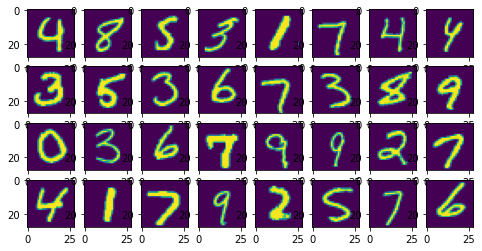

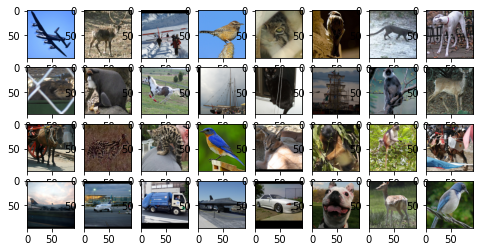

In [10]:
def show(imgs):
    # your code goes here:
  plt.figure(figsize=(8, 4))
  for i, item in enumerate(imgs):
      if i >= 32:
#        print('indexes error')
        break
      plt.subplot(4, 8, i+1)
#      img = item.numpy().transpose((1, 2, 0))
      plt.imshow(item)
#      plt.imshow(item[0].squeeze().numpy())

  return None

def show_random_images(imgs_nparray, N):
  xs = []
  for i in range(N):
    sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
    img = imgs_nparray[sample_idx]
    xs.append(img)
  show(xs)

print('Random MNIST images:')
show_random_images(mnist_train_split.data, 32)
print('Random STL10 images:')
show_random_images(stl10_train_split, 32)



## Extrapolate in the image domain

Here, we randomly take 2 images from the training dataset, combine them together and plot the result. For example, consider $X_1$ and $X_2$ to be 2 images randomly taken from the training data. Plot $\alpha\cdot X_1 + (1-\alpha)\cdot X_2$. 

As expected, the extrapolation in the image domain is not reasonable, as we can see on resulting images.


Extrapolate MNIST images in the image domain:
img.shape: torch.Size([28, 28])
Extrapolate STL10 images in the image domain:
img.shape: (96, 96, 3)


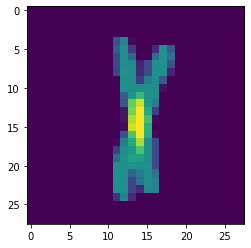

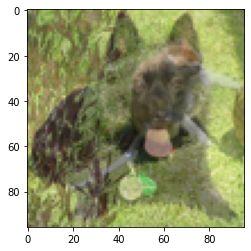

In [11]:
def extrapolte_images(imgs_nparray):
  sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
  img1 = imgs_nparray[sample_idx]
  sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
  img2 = imgs_nparray[sample_idx]
  alpha = 0.5

  img = alpha*img1 + (1-alpha)*img2
#  img = img3.numpy().transpose((1, 2, 0))
  plt.figure(clear=True)
  plt.imshow(img)
  print(f'img.shape: {img.shape}')

print('Extrapolate MNIST images in the image domain:')
extrapolte_images(mnist_train_split.data)
print('Extrapolate STL10 images in the image domain:')
extrapolte_images(stl10_train_split)



# Unsupervised Learning

## VAE Implementation

To extract features from dataset of images we use convolutional neural network (CNN). Hence, we use a convolutional VAEfor unsupervised learning.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** is comprised of convolutional layers (nn.Conv2d). We fit the dimension of the input images according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.

**The decoder** reconstructs the images from the latent space. In order to enlarge dimensions of images, our network is comprised of transposed convolutional layers (nn.ConvTranspose2d).


### Encoder

Here, we implement the architecture of the encoder. 

The encoder consists of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, we add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).


In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent, input_shape=(1, 28, 28)):
        super(Encoder, self).__init__()
        # YOUR CODE GOES HERE:
        print(f'Encoder: in_channels: {in_channels}, num_hiddens: {num_hiddens}, latent: {latent}, input_shape: {input_shape}')
        self.kernel_size = 3
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.num_hiddens = num_hiddens
        self.latent = latent
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*2)
            nn.BatchNorm2d(num_hiddens*2),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*4)
            nn.BatchNorm2d(num_hiddens*4),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*8)
            nn.BatchNorm2d(num_hiddens*8),
            nn.ReLU()

        )
        self.flatten = torch.nn.Flatten()
        self.relu = torch.nn.ReLU()
      # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*num_hiddens channels
      # thus, Linear input shape: (8*num_hiddens)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))

        # n_linear_size = int(((image_h-3)/2 + 1)**2)
        print(f'fc1_inp: {fc1_inp}')
        self.fc_mu = nn.Linear(fc1_inp, latent)     # Insert the input size
        self.fc_logvar = nn.Linear(fc1_inp, latent) # Insert the input size

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'encoder forward: inputs.shape: {inputs.shape}')
        x = self.block1(inputs)
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.block2(x)
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.block3(x)
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.block4(x)
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        #x.view(-1, image_h*image_w*3), self.num_hiddens, self.latent
        x = self.flatten(x)
        if DEBUG_NN:
          print(f'flatten(x): x.shape: {x.shape}')
#        print(f'fc1(x): z.shape: {z.shape}')
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        if DEBUG_NN:
          print(f'encoder forward: fc_logvar(x): mu.shape, logvar.shape: {mu.shape}, {logvar.shape}')
        return mu, logvar

### Decoder

Here, we implement the architecture of the decoder. 

First, we apply a linear layer to the input of the decoder as follows:

- nn.Linear(latent, ___ ).

The output of the linear layer matches to $Batch\cdot H_4\cdot W_4\cdot C_4$, which were the same parameters from the encoder 4'th block's output.

Then, the decoder consists of 4 Blocks as follows:

BLOCK 1: 
- Transposed Convolutional layer (nn.ConvTranspose2d(in_channels, num_hidden // 2, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 2)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 2: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 2, num_hidden // 4, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 4)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 3: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 4, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 4: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 8, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()


Afterwards, we generate an image in the same size as our input images. Thus added 1 more block consisting of:

BLOCK 5:
 - nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
 - Activation function.


In [13]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens,latent, input_shape=(1, 28, 28)):
        super(Decoder, self).__init__()
        # YOUR CODE GOES HERE:
        print(f'Decoder: in_channels: {in_channels}, num_hiddens: {num_hiddens}, latent: {latent}, input_shape: {input_shape}')
        self.kernel_size = 4
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.latent = latent
        self.num_hiddens = num_hiddens

        # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*n channels
        # thus, Linear input shape: (8*n)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))
        img_s = (self.H*self.W)//2**8

        self.fc_dec = nn.Linear(latent, fc1_inp) # Insert the output size

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(fc1_inp // img_s, num_hiddens // 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 2),
            nn.LeakyReLU(0.1)
            )
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 4),
            nn.LeakyReLU(0.1)
            )

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU(0.1)
            )
        
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 8, num_hiddens // 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU(0.1)
            )

        self.block5 = nn.Sequential( # Add convolution layer and activation layer
            nn.Conv2d(num_hiddens // 8, 3, kernel_size=(3,3), stride=(1,1), padding=1),
            # Batch Normalization(num_hidden)
            nn.LeakyReLU(0.1)
            )

        self.flatten = torch.nn.Flatten()
        self.le_relu = torch.nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'decoder forward: inputs.shape: {inputs.shape}')

        x = self.fc_dec(inputs)
        if DEBUG_NN:
          print(f'fc_dec(x): x.shape: {x.shape}')

        H = int(self.H/(2**4))
        W = int(self.W/(2**4))
        C = int(8*self.num_hiddens)
        x = x.reshape(-1,C,H,W)
#        x = x.view(N,C,H,W)
        if DEBUG_NN:
          print(f'reshaped x: x.shape: {x.shape}')


        x = self.block1(x)
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.block2(x)
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.block3(x)
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.block4(x)
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        x = self.block5(x)
        if DEBUG_NN:
          print(f'block5(x): x.shape: {x.shape}')

        x_rec = self.sigmoid(x)
        if DEBUG_NN:
          print(f'decoder forward: sigmoid(x): x_rec.shape: {x_rec.shape}')

        return x_rec

### VAE Model

Once we have the architecture of the encoder and the decoder, we want to put them together and train the network end-to-end.

In VAEs, we need to sample from a gaussian distribution at the input of the decoder. In order to backpropagate through the network, we use the reparametrization trick. The reparametrization trick is saying that sampling from $𝑧∼N(\mu,\sigma)$ is equivalent to sampling $\varepsilon∼N(0,1)$ and setting $𝑧=\mu+\sigma⊙\varepsilon$. Where, epsilon is an input to the network while keeping your sampling operation differentiable.
The reparametrization function is given to you in the VAE class.


In [14]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent, input_shape=(1, 28, 28)):
        super(VAE, self).__init__()
        self.num_hidden = dec_num_hidden
        self.latent = latent
        self.encode = Encoder(in_channels = enc_in_chnl, num_hiddens = enc_num_hidden,latent = latent, input_shape = input_shape)
        self.decode = Decoder(in_channels = dec_in_chnl, num_hiddens = dec_num_hidden,latent = latent, input_shape = input_shape)

    # Reparametrization Trick
    def reparametrize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)     
      return eps.mul(std).add_(mu)

    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'VAE forward: inputs.shape: {x.shape}')

        mu, logvar = self.encode(x)
        if DEBUG_NN:
          print(f'VAE forward: mu.shape, logvar.shape: {mu.shape}, {logvar.shape}')
        z = self.reparametrize(mu, logvar)
        if DEBUG_NN:
          print(f'z.shape: {z.shape}')

        x_rec = self.decode(z)
        if DEBUG_NN:
          print(f'VAE forward: x_rec.shape: {x_rec.shape}')

        return x_rec , mu, logvar


## ELBO
The $ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$ is comprised of 2 terms. Explain the meaning of each one of them in terms of a loss function.



### Loss Function

The loss function is based on the ELBO; Over a batch in the dataset, it can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

**$\beta$-Variational Autoencoder ($\beta$-VAE)**

The fact that the ELBO is comprised of the sum of two loss terms implies that these can be balanced using an additional hyperparameter $\beta$, i.e.,

$\beta\cdot D_{KL}\big(q(z|x_i)||P(z)\big) - E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

The DKL term is regularization term, and the E() is reconstruction term. The hyperparameter $\beta$ in the loss function that controls the balance between these two terms. With $\beta < 1$,
the reconstruction term has stronger effect on the ELBO result. It will cause the trained model to emphisize the reconstruction of the inputs  over the latent regularization. Very small $\beta$ value can cause the model overfitting.
With high $\beta$ the trained model will prefer the regularization term that might cause to poor reconstruction results and lead to underfitting.
We use large $\beta < 1$ to cause the model training to emphisize on KLD, since we are less interested in recosntruction quality.
 

In [15]:
beta = 0.8
def vae_loss(x_recon, x, mu, logvar):
# Reconstruction + KL divergence losses summed over all elements and batch
    if DEBUG_NN:
      print(f'vae_loss: x_recon.shape, x.shape: {x_recon.shape}, {x.shape}')
    MSE = nn.functional.mse_loss(
        x, x_recon, reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    return MSE + KLD*beta


## VAE Training



### Training function

In [16]:
#def plot_learning_curve(iters, losses, epocs_vec, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg):
def plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(epocs_vec, train_losses, label="Train")

    plt.plot(epocs_vec, test_losses, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [17]:
def train(dataset, model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3, batch_size=10, train_dataset_size=64, test_dataset_size=64):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_iters, test_iters, train_losses, test_losses, epocs_vec = [], [], [], [], []
    codes = dict(μ=list(), logσ2=list(), label=list())
    model.train()
    n = 0 # total number of iterations
    nt = 0 # total number of test iterations
    img = None
    x_recon = None

    for epoch in range(num_epochs):
      train_loss = 0
      for batch_idx, batch in enumerate(train_loader):
        if dataset == 'Mnist':
          imgs, y = batch
        else:
          imgs = batch
          # reshape - for STL10
          N, H, W, C = imgs.shape
          imgs = imgs.view(N,C,H,W)
#        print(f'train imgs11.shape: {imgs11.shape}')
        imgs = imgs.to(dev)
        if DEBUG:
          print(f'train imgs.shape: {imgs.shape}')

#        print(f'train imgs.shape: {imgs.shape}')
        # Since the dataset is large, train on 'train_dataset_size' samples.
        if train_dataset_size//batch_size == batch_idx: 
            break


        # ===================forward=====================
        x_recon, mu, logvar = model(imgs)
        loss = vae_loss(x_recon, imgs, mu, logvar)
        train_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        n += 1
        train_iters.append(n)

      # Testing - once per epoch
      means, logvars = list(), list()
      with torch.no_grad():
          model.eval()
          test_loss = 0
          for batch_idx, batch in enumerate(test_loader):
              if dataset == 'Mnist':
                img, y = batch
              else:
                img = batch
                N, H, W, C = img.shape
                img = img.view(N,C,H,W)
              img = img.to(dev)
              # Since the test dataset is large, train on 'test_dataset_size' samples.
              if test_dataset_size//batch_size == batch_idx: 
                  break
              if DEBUG:
                print(f'test img.shape: {img.shape}')
              # ===================forward=====================
              x_recon, mu, logvar = model(img)
              test_loss += vae_loss(x_recon, img, mu, logvar).item()
              # =====================log=======================
              # save the current training information
              nt += 1
              test_iters.append(nt)

              means.append(mu.detach())
              logvars.append(logvar.detach())
          # ===================log========================
          codes['μ'].append(torch.cat(means))
          codes['logσ2'].append(torch.cat(logvars))


        # ===================log========================
      epocs_vec.append(epoch)
      test_loss = float(test_loss)/test_dataset_size
      train_loss = float(train_loss)/train_dataset_size
      test_losses.append(test_loss)  # compute *average* loss
      train_losses.append(train_loss)  # compute *average* loss
      print(f"Epoch {epoch}, Train Iter {n}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}")


    # saved statistics and the last batch
    return train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img


## Train Unsupervised Models


 ### Train STL10 CNN

#### Train toy STL10 Model


Encoder: in_channels: 3, num_hiddens: 32, latent: 3, input_shape: (3, 96, 96)
fc1_inp: 9216
Decoder: in_channels: 32, num_hiddens: 256, latent: 3, input_shape: (3, 96, 96)
Epoch 0, Train Iter 100, train_loss: 1652.8962, test_loss: 1511.3337
Epoch 1, Train Iter 200, train_loss: 1487.6064, test_loss: 1384.3694
Epoch 2, Train Iter 300, train_loss: 1301.0124, test_loss: 1249.4323
Epoch 3, Train Iter 400, train_loss: 1252.3230, test_loss: 1242.4604
Epoch 4, Train Iter 500, train_loss: 1238.7386, test_loss: 1219.5657
Epoch 5, Train Iter 600, train_loss: 1219.5231, test_loss: 1205.8591
Epoch 6, Train Iter 700, train_loss: 1215.7653, test_loss: 1202.8937
Epoch 7, Train Iter 800, train_loss: 1206.8338, test_loss: 1199.1093
Epoch 8, Train Iter 900, train_loss: 1199.3780, test_loss: 1184.8026
Epoch 9, Train Iter 1000, train_loss: 1184.4801, test_loss: 1187.2136


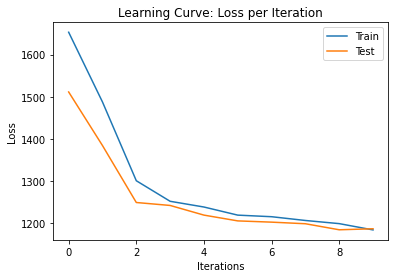

In [18]:
# Your Code Goes Here
def train_stl10_toy():
  learning_rate = 2e-3
  batch_size = 50
  num_epochs = 10
  #dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.
  dataset_size = 600 # How many data samples to use for training, 30,000 should be enough.
  train_dataset_size = stl10_train_split.shape[0]
  test_dataset_size = stl10_test_split.shape[0]
  #train_dataset_size = 3000
  #test_dataset_size = 1000

  #VAE Class inputs: 
  enc_in_chnl = 3
  enc_num_hidden = 32
  dec_in_chnl = 32
  dec_num_hidden = 256
  latent1 = 3

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None

  # Train STL10
  # set STL10 image size
  # image shape
  #HEIGHT = 96
  #WIDTH = 96
  #DEPTH = 3
  image_shape = (3, 96, 96)
  # resize the images


  train_loader = torch.utils.data.DataLoader(stl10_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(stl10_test_split, batch_size=batch_size, shuffle=True) 

  model_1 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent1, input_shape=image_shape)
  model_1.to(dev)
  model_1.weight_init(mean=0, std=0.02)
  train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train('STL10',
      model_1, train_loader, test_loader, num_epochs,
      learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)
  return model_1, x_recon, img

DEBUG = False
DEBUG_NN = False
if TRAIN:
  model_1, x_recon_stl10, img_stl10 = train_stl10_toy()


#### Visualize reconstructed images

As we can see from the reconstruction results below, the reconstruction quality is poor. The reconstructed images look very blur. It seems that latent of dimension 3 is not able to capture the mappings from trained images to the AE latent domain.

img.shape: torch.Size([50, 3, 96, 96])
in_pics.shape: torch.Size([50, 3, 96, 96])


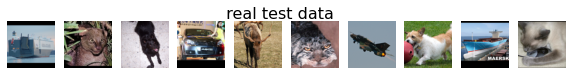

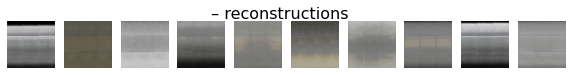

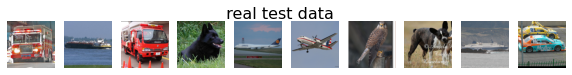

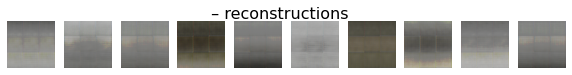

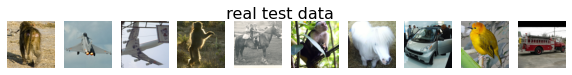

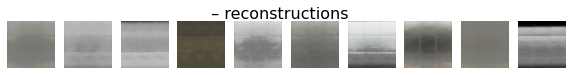

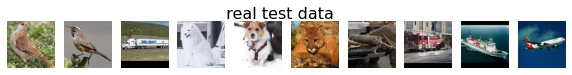

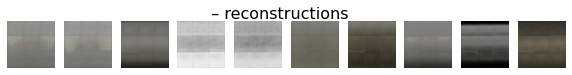

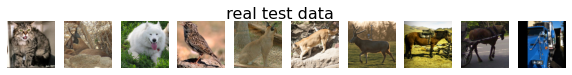

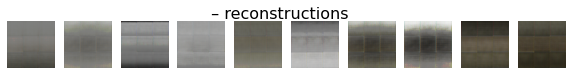

In [19]:
def display_images(imgs, x_recon = None, X=1, label='', count=False):
    in_pics = imgs.data.cpu()
    if x_recon is not None:
      out_pics = x_recon.data.cpu()
    print(f'in_pics.shape: {in_pics.shape}')
    Y = len(in_pics)//X
    for i in range(X):
      plt.figure(figsize=(10, 1.1))
      plt.suptitle(label + ' real test data', fontsize=16)
      for j in range(Y):
          plt.subplot(1,Y,j+1)

          N, C, H, W = in_pics.shape
          in_pic = in_pics.view(N,H,W,C)[j+Y*i]
          plt.imshow(in_pic)
          plt.axis('off')
      if x_recon is not None:
          plt.figure(figsize=(10, 1.1))
          plt.suptitle(label + ' – reconstructions', fontsize=16)
          for j in range(Y):
              plt.subplot(1,Y,j+1)
              N, C, H, W = out_pics.shape
              out_pic = out_pics.view(N,H,W,C)[j+Y*i]
              plt.imshow(out_pic)
              plt.axis('off')


#print(f'Sample images:')
#show(img.cpu())
#print(f'Recon of Sample images:')
#show(x_recon.cpu())
if TRAIN:
  print(f'img.shape: {img_stl10.shape}')
  display_images(img_stl10, x_recon_stl10, X=5, label='', count=False)


#### Train STL10 Model

Next, we train with larger $Latent = 200$


train_dataset_size: 5000, test_dataset_size: 8000
Encoder: in_channels: 3, num_hiddens: 32, latent: 200, input_shape: (3, 96, 96)
fc1_inp: 9216
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (3, 96, 96)
Epoch 0, Train Iter 100, train_loss: 2864.5213, test_loss: 1729.6458
Epoch 1, Train Iter 200, train_loss: 1647.4735, test_loss: 1527.9729
Epoch 2, Train Iter 300, train_loss: 1501.9721, test_loss: 1435.8294
Epoch 3, Train Iter 400, train_loss: 1353.3597, test_loss: 1289.2741
Epoch 4, Train Iter 500, train_loss: 1262.3025, test_loss: 1236.4937
Epoch 5, Train Iter 600, train_loss: 1215.1924, test_loss: 1188.4782
Epoch 6, Train Iter 700, train_loss: 1159.6928, test_loss: 1122.1481
Epoch 7, Train Iter 800, train_loss: 1111.4180, test_loss: 1096.1737
Epoch 8, Train Iter 900, train_loss: 1088.1755, test_loss: 1072.1782
Epoch 9, Train Iter 1000, train_loss: 1073.4883, test_loss: 1066.8440
Epoch 10, Train Iter 1100, train_loss: 1064.9593, test_loss: 1059.8530
Epoch 11, Tr

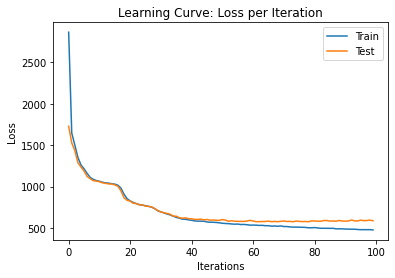

In [20]:
def train_stl10(learning_rate = 2e-3, batch_size = 50, num_epochs = 100, latent2 = 200):

  #learning_rate = 2e-3
  #batch_size = 50
  #num_epochs = 100

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None
  train_dataset_size = stl10_train_split.shape[0]
  test_dataset_size = stl10_test_split.shape[0]
  print(f'train_dataset_size: {train_dataset_size}, test_dataset_size: {test_dataset_size}')
  DEBUG = False
  DEBUG_NN = False

  #VAE Class inputs: 
  enc_in_chnl = 3
  enc_num_hidden = 32
  dec_in_chnl = 32
  dec_num_hidden = 256
  latent2 = 200


  # Train STL10
  # set STL10 image size
  # image shape
  # resize the images
  image_shape = (3, 96, 96)


  train_loader = torch.utils.data.DataLoader(stl10_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(stl10_test_split, batch_size=batch_size, shuffle=True) 

  model_2 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent2, input_shape=image_shape)
  model_2.to(dev)
  model_2.weight_init(mean=0, std=0.02)
  train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train('STL10',
      model_2, train_loader, test_loader, num_epochs,
      learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)
  return model_2, x_recon, img

if TRAIN:
  #model_2_stl10, x_recon, img = train_stl10()
  model_2_stl10, x_recon, img = train_stl10(learning_rate = 2e-3, batch_size = 50, num_epochs = 100, latent2 = 200)


in_pics.shape: torch.Size([50, 3, 96, 96])


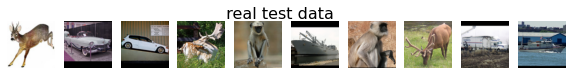

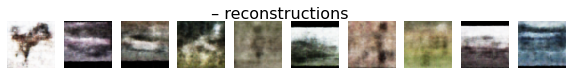

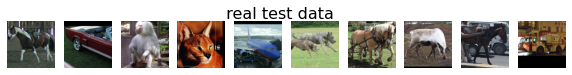

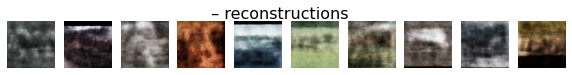

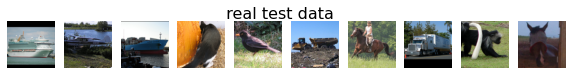

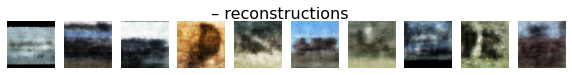

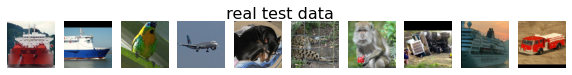

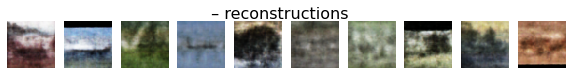

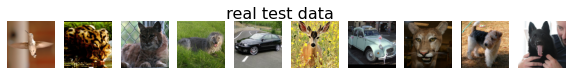

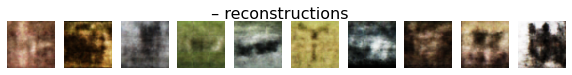

In [21]:
if TRAIN:
  imgs_stl1 = img[:50]
  x_recon_stl1 = x_recon[:50]
  display_images(imgs_stl1, x_recon_stl1, X=5, label='', count=False)


#### Train STL10 Model with $beta = 0.2$


train_dataset_size: 5000, test_dataset_size: 8000
Encoder: in_channels: 3, num_hiddens: 32, latent: 200, input_shape: (3, 96, 96)
fc1_inp: 9216
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (3, 96, 96)
Epoch 0, Train Iter 100, train_loss: 7335.6606, test_loss: 2086.4388
Epoch 1, Train Iter 200, train_loss: 1573.0094, test_loss: 1332.2722
Epoch 2, Train Iter 300, train_loss: 1258.1078, test_loss: 1217.3772
Epoch 3, Train Iter 400, train_loss: 1200.3345, test_loss: 1183.2867
Epoch 4, Train Iter 500, train_loss: 1151.3437, test_loss: 1092.8750
Epoch 5, Train Iter 600, train_loss: 1078.5869, test_loss: 1063.1185
Epoch 6, Train Iter 700, train_loss: 1051.3336, test_loss: 1039.5514
Epoch 7, Train Iter 800, train_loss: 1032.1346, test_loss: 1022.8462
Epoch 8, Train Iter 900, train_loss: 1018.0366, test_loss: 1014.4811
Epoch 9, Train Iter 1000, train_loss: 1012.7520, test_loss: 1008.5927
Epoch 10, Train Iter 1100, train_loss: 1004.0428, test_loss: 1002.2380
Epoch 11, Tr

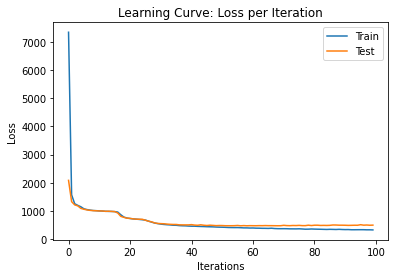

In [22]:
if TRAIN:
  beta = 0.2
  model_beta2_stl10, x_recon, img = train_stl10(learning_rate = 2e-3, batch_size = 50, num_epochs = 100, latent2 = 200)
  beta = 0.8

### Train MNIST CNN

#### Train toy MNIST Model


train_dataset_size: 12000, test_dataset_size: 2000
Encoder: in_channels: 1, num_hiddens: 32, latent: 3, input_shape: (1, 32, 32)
fc1_inp: 1024
Decoder: in_channels: 32, num_hiddens: 256, latent: 3, input_shape: (1, 32, 32)


<ipython-input-15-86394ff56637>:6: UserWarning: Using a target size (torch.Size([50, 3, 32, 32])) that is different to the input size (torch.Size([50, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = nn.functional.mse_loss(


Epoch 0, Train Iter 240, train_loss: 189.8326, test_loss: 110.6768
Epoch 1, Train Iter 480, train_loss: 105.6210, test_loss: 101.5221
Epoch 2, Train Iter 720, train_loss: 98.9682, test_loss: 96.4997
Epoch 3, Train Iter 960, train_loss: 94.5204, test_loss: 92.1773
Epoch 4, Train Iter 1200, train_loss: 92.3483, test_loss: 94.4202
Epoch 5, Train Iter 1440, train_loss: 91.2290, test_loss: 91.8068
Epoch 6, Train Iter 1680, train_loss: 89.1966, test_loss: 88.1244
Epoch 7, Train Iter 1920, train_loss: 88.9815, test_loss: 89.1163
Epoch 8, Train Iter 2160, train_loss: 87.6543, test_loss: 88.0434
Epoch 9, Train Iter 2400, train_loss: 86.0340, test_loss: 86.7562


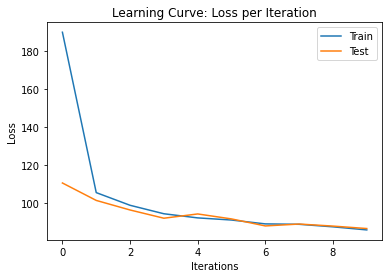

In [23]:
# Train MNIST
def train_mnist_toy():
  # Your Code Goes Here
  learning_rate = 2e-3
  batch_size = 50
  num_epochs = 10
  #dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.
  dataset_size = 600 # How many data samples to use for training, 30,000 should be enough.
  train_dataset_size = mnist_train_split.data.shape[0]//5
  test_dataset_size = mnist_test_split.data.shape[0]//5
  #train_dataset_size = 3000
  #test_dataset_size = 1000
  print(f'train_dataset_size: {train_dataset_size}, test_dataset_size: {test_dataset_size}')

  #VAE Class inputs: 
  enc_in_chnl = 1
  enc_num_hidden = 32
  dec_in_chnl = 32
  dec_num_hidden = 256
  latent1 = 3

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None

  # Train MNIST
  # set MNIST image size
  #image_c, image_h, image_w = (1, 28, 28)
  image_shape = (1, 32, 32)
#  image_size = (28, 28)
  # add channel dimension to image tensor

  train_loader = torch.utils.data.DataLoader(mnist_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(mnist_test_split, batch_size=batch_size, shuffle=True) 

  model_1 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent1, input_shape=image_shape)
  model_1.to(dev)
  model_1.weight_init(mean=0, std=0.02)
  train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train('Mnist',
      model_1, train_loader, test_loader, num_epochs,
      learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)
  return model_1, x_recon, img

#DEBUG = True
#DEBUG_NN = True
if TRAIN:
  model_1_mnist, x_recon_mnist, imgs_mnist = train_mnist_toy()


#### Visualize reconstructed images

in_pics.shape: (50, 1, 32, 32)


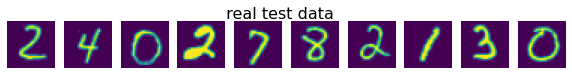

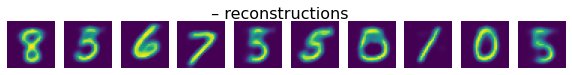

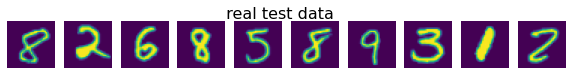

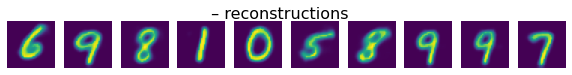

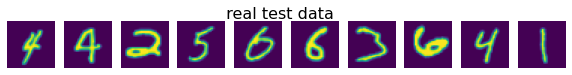

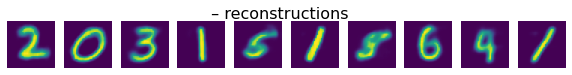

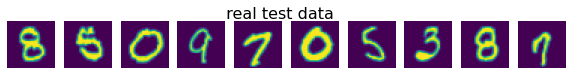

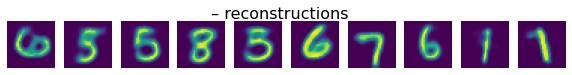

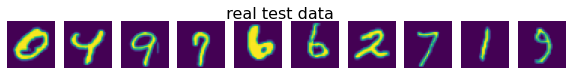

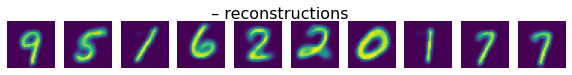

In [24]:
def display_images_mnist(imgs, x_recon = None, X=1, label='', count=False):
    in_pics = imgs.data.cpu()
    in_pics = in_pics.detach().numpy()
    if x_recon is not None:
      out_pics = x_recon.data.cpu()
      out_pics = out_pics.detach().numpy()
    print(f'in_pics.shape: {in_pics.shape}')
    Y = len(in_pics)//X
    for i in range(X):
      plt.figure(figsize=(10, 1.1))
      plt.suptitle(label + ' real test data', fontsize=16)
      for j in range(Y):
          plt.subplot(1,Y,j+1)
          in_pic = in_pics[j+Y*i,0]
          plt.imshow(in_pic)
          plt.axis('off')
      if x_recon is not None:
          plt.figure(figsize=(10, 1.1))
          plt.suptitle(label + ' – reconstructions', fontsize=16)
          for j in range(Y):
              plt.subplot(1,Y,j+1)
              out_pic = out_pics[j+Y*i,0]
              plt.imshow(out_pic)
              plt.axis('off')
if TRAIN:
  display_images_mnist(imgs_mnist, x_recon_mnist, X=5, label='', count=False)


#### Train MNIST Model


Plot the train and the validation loss graphs.

Eventually, after playing with hyperparameters, we see stable training process with training loss going down on each iteration. We see unusually high loss values - thousands, hundreds. We tried to lower these numbers to be less than 1. It can be done by, for example, changing the 'sum' reduction in MSE loss calculation to 'mean', but it doesn't really improves the model performance, so we decided to stay as is.

train_dataset_size: 60000, test_dataset_size: 10000
Encoder: in_channels: 1, num_hiddens: 32, latent: 200, input_shape: (1, 32, 32)
fc1_inp: 1024
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (1, 32, 32)


<ipython-input-15-86394ff56637>:6: UserWarning: Using a target size (torch.Size([50, 3, 32, 32])) that is different to the input size (torch.Size([50, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = nn.functional.mse_loss(


Epoch 0, Train Iter 1200, train_loss: 99.7251, test_loss: 57.7255
Epoch 1, Train Iter 2400, train_loss: 52.3994, test_loss: 48.7179
Epoch 2, Train Iter 3600, train_loss: 48.0943, test_loss: 47.2079
Epoch 3, Train Iter 4800, train_loss: 46.0748, test_loss: 45.0118
Epoch 4, Train Iter 6000, train_loss: 44.7947, test_loss: 44.0655
Epoch 5, Train Iter 7200, train_loss: 43.8015, test_loss: 43.2829
Epoch 6, Train Iter 8400, train_loss: 43.0654, test_loss: 42.8723
Epoch 7, Train Iter 9600, train_loss: 42.4860, test_loss: 42.1046
Epoch 8, Train Iter 10800, train_loss: 41.9476, test_loss: 42.4470
Epoch 9, Train Iter 12000, train_loss: 41.5609, test_loss: 41.3027
Epoch 10, Train Iter 13200, train_loss: 41.0555, test_loss: 41.8889
Epoch 11, Train Iter 14400, train_loss: 40.7322, test_loss: 40.8089
Epoch 12, Train Iter 15600, train_loss: 40.4581, test_loss: 40.6673
Epoch 13, Train Iter 16800, train_loss: 40.1630, test_loss: 40.3684
Epoch 14, Train Iter 18000, train_loss: 39.9381, test_loss: 40.150

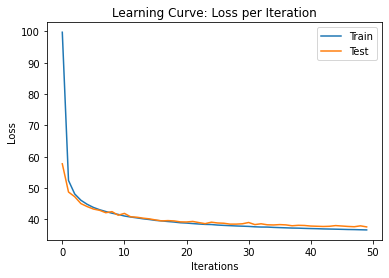

In [25]:
# Train MNIST
def train_mnist(learning_rate = 2e-3, batch_size = 50, num_epochs = 100, latent1 = 200):
  # Your Code Goes Here
#  learning_rate = 2e-3
#  batch_size = 100
#  num_epochs = 20
  train_dataset_size = mnist_train_split.data.shape[0]
  test_dataset_size = mnist_test_split.data.shape[0]
  #train_dataset_size = 3000
  #test_dataset_size = 1000
  print(f'train_dataset_size: {train_dataset_size}, test_dataset_size: {test_dataset_size}')

  #VAE Class inputs: 
  enc_in_chnl = 1
  enc_num_hidden = 32
  dec_in_chnl = 32
  dec_num_hidden = 256
#  latent1 = 200

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None

  # Train MNIST
  # set MNIST image size
  image_shape = (1, 32, 32)
  
  train_loader = torch.utils.data.DataLoader(mnist_train_split, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(mnist_test_split, batch_size=batch_size, shuffle=True) 

  model_1 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent1, input_shape=image_shape)
  model_1.to(dev)
  model_1.weight_init(mean=0, std=0.02)
  train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train('Mnist',
      model_1, train_loader, test_loader, num_epochs,
      learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)
  return model_1, x_recon, img

#DEBUG = True
#DEBUG_NN = True
TRAIN = True
if TRAIN:
  model_2_mnist, imgs_mnist, x_recon_mnist = train_mnist(learning_rate = 2e-3, batch_size = 50, num_epochs = 50, latent1 = 200)


Visualize, from the test dataset, an original image against a reconstructed image.

in_pics.shape: (50, 3, 32, 32)


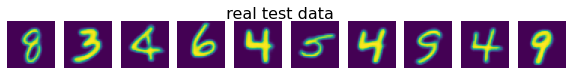

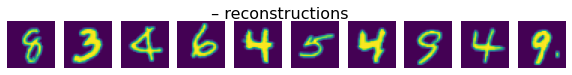

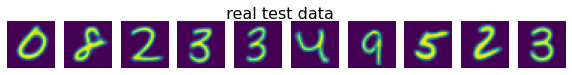

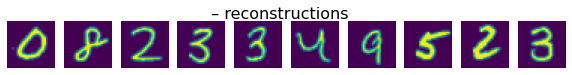

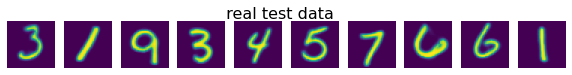

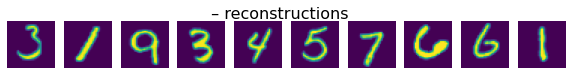

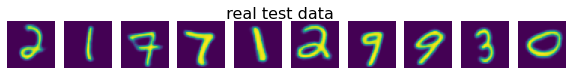

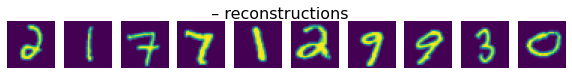

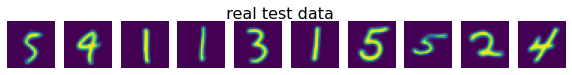

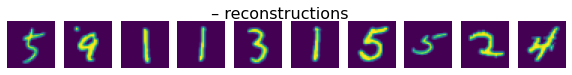

In [26]:
if TRAIN:
  imgs_mnist1 = imgs_mnist[:50]
  x_recon_mnist1 = x_recon_mnist[:50]
  display_images_mnist(imgs_mnist1, x_recon_mnist1, X=5, label='', count=False)


#### Train MNIST Model with $beta=0.2$

In [ ]:
if TRAIN:
  beta = 0.2
  model_beta2_mnist, x_recon, img = train_mnist(learning_rate = 2e-3, batch_size = 50, num_epochs = 50, latent1 = 200)
  beta = 0.8

train_dataset_size: 60000, test_dataset_size: 10000
Encoder: in_channels: 1, num_hiddens: 32, latent: 200, input_shape: (1, 32, 32)
fc1_inp: 1024
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (1, 32, 32)


<ipython-input-15-86394ff56637>:6: UserWarning: Using a target size (torch.Size([50, 3, 32, 32])) that is different to the input size (torch.Size([50, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = nn.functional.mse_loss(


Epoch 0, Train Iter 1200, train_loss: 75.4435, test_loss: 34.3017
Epoch 1, Train Iter 2400, train_loss: 29.0300, test_loss: 26.1017
Epoch 2, Train Iter 3600, train_loss: 25.3434, test_loss: 23.9065
Epoch 3, Train Iter 4800, train_loss: 23.8432, test_loss: 23.0814
Epoch 4, Train Iter 6000, train_loss: 22.9103, test_loss: 22.2777
Epoch 5, Train Iter 7200, train_loss: 22.2277, test_loss: 22.0173


 What will happened if we choose extremely high dimension for the latent space? 

In [ ]:
if TRAIN:
  str1 = '_{}'.format(beta)
  model_path_mnist_beta = model_path_mnist.split('.')[0] + str1 + '.pk'
  print(str1)
  print(model_path_mnist_beta)

### Save Trained Models

In [ ]:
if TRAIN:
  from google.colab import drive
  drive.mount('/content/gdrive')

  # Save model in GDrive for future use
  if (model_path_stl10 is not None):
      torch.save(model_2_stl10.state_dict(), model_path_stl10)
  if (model_path_mnist is not None):
      torch.save(model_2_mnist.state_dict(), model_path_mnist)

  str1 = '_{}'.format(beta)
  model_path_mnist_beta = model_path_mnist.split('.')[0] + str1 + '.pk'
  if (model_path_mnist is not None):
      torch.save(model_beta2_mnist.state_dict(), model_path_mnist_beta)

  model_path_stl10_beta = model_path_stl10.split('.')[0] + str1 + '.pk'
  if (model_path_stl10 is not None):
      torch.save(model_beta2_stl10.state_dict(), model_path_stl10_beta)


# Supervised Learning

## CNN Implementation

### CNN Architecture

Here, we implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).


In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_hiddens, numb_classes, input_shape=(1, 28, 28)):
        super(CNN, self).__init__()
        print(f'CNN: in_channels: {in_channels}, num_hiddens: {num_hiddens}, numb_classes: {numb_classes}, input_shape: {input_shape}')
        self.kernel_size = 3
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.num_hiddens = num_hiddens
        self.numb_classes = numb_classes
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*2)
            nn.BatchNorm2d(num_hiddens*2),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*4)
            nn.BatchNorm2d(num_hiddens*4),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*8)
            nn.BatchNorm2d(num_hiddens*8),
            nn.ReLU()

        )
        self.flatten = torch.nn.Flatten()
        self.le_relu = torch.nn.LeakyReLU(0.1)
        self.relu = torch.nn.ReLU()
        self.logsoftmax = torch.nn.LogSoftmax(dim=1)
      # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*num_hiddens channels
      # thus, Linear input shape: (8*num_hiddens)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))

        self.fc1 = torch.nn.Linear(in_features=fc1_inp, out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=numb_classes)

        # n_linear_size = int(((image_h-3)/2 + 1)**2)
#        print(f'fc1_inp: {fc1_inp}')
#        self.fc_mu = nn.Linear(fc1_inp, latent)     # Insert the input size
#        self.fc_logvar = nn.Linear(fc1_inp, latent) # Insert the input size

    # Initialize Weights - TODO: lets try it
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'encoder forward: inputs.shape: {inputs.shape}')
        x = self.le_relu(self.block1(inputs))
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.le_relu(self.block2(x))
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.le_relu(self.block3(x))
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.le_relu(self.block4(x))
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        #x.view(-1, image_h*image_w*3), self.num_hiddens, self.latent
        x = self.flatten(x)
        if DEBUG_NN:
          print(f'flatten(x): x.shape: {x.shape}')

        y = self.relu(self.fc1(x))
        y = self.fc2(y)
        out = self.logsoftmax(y)
#        print(f'fc1(x): z.shape: {z.shape}')
#        mu = self.fc_mu(x)
#        logvar = self.fc_logvar(x)
        if DEBUG_NN:
          print(f'log_softmax out.shape: {out.shape:}')
        return out

### Loss Function


In [ ]:
def get_accuracy_cnn(dataset, model, data_loader, dataset_size, stl10_labels_split, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    # TODO: pass relevant data split
    # interact the data split
#    if DEBUG:
#      print(f'get_accuracy run')

    with torch.no_grad():
        model.eval()
        correct = 0
        labels_idx = 0
        for batch_idx, batch in enumerate(data_loader):
            labels = []
            if dataset == 'Mnist':
              img, labels = batch
#              labels = labels.cpu().detach().numpy().tolist()
              labels = labels.cpu().detach().numpy()
            else:
              img = batch
              N, H, W, C = img.shape
              img = img.view(N,C,H,W)
              labels = stl10_labels_split[labels_idx:(labels_idx+batch_size)]
              labels_idx += batch_size
            img = img.to(dev)
#            oh_labels = torch.Tensor(np.array(np.eye(10)[labels])).to(dev)
            if dataset_size//batch_size == batch_idx: 
                break
#            if DEBUG:
#              print(f'get_accuracy: test img.shape: {img.shape}')
            # ===================forward=====================
            zs = model(img)
            pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
            pred = pred.cpu().detach().numpy()
#            print(f'pred: {pred}')
#            print(f'pred.shape: {pred.shape}')
#            print(f'labels.shape: {labels.shape}')
#            print(f'type(labels): {type(labels)}')
#            print(f'labels: {labels}')
#            tt = pred == labels
#            print(f'tt: {tt}')
#            print(f'oh_labels.shape: {oh_labels.shape}')
#            tt = pred == oh_labels
#            print(f'tt with oh_labels: {tt}')
            correct += (pred == labels).sum()
#            correct += (pred == 1).sum()

    return correct / dataset_size

## CNN Training



### Training function

In [ ]:
def plot_learning_curve_cnn(iters, losses, epocs_vec, train_accs, test_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Epoch")
    plt.plot(epocs_vec, train_accs, label="Train")
    plt.plot(epocs_vec, test_accs, label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
'''
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle("Learning Curve: Accuracy per Epoch")

    axs[0].plot(epocs_vec, train_accs, label="Train")
    axs[0].plot(epocs_vec, test_accs, label="Test")
    axs[0].set_title('Train vs Test Accuracy')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
'''
    

In [ ]:
def train_cnn(dataset, model, numb_classes, train_loader, test_loader, num_epochs=10, learning_rate=1e-3, batch_size=10, train_dataset_size=64, test_dataset_size=64, weight_decay=0):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#    train_iters, test_iters, train_losses, test_losses, epocs_vec = [], [], [], [], []

    iters, losses = [], []
    epocs_vec, train_losses, test_losses, train_accs, test_accs  = [], [] ,[], [] ,[]

    n = 0 # total number of iterations
    nt = 0 # total number of test iterations

    for epoch in range(num_epochs):
      model.train()
      train_loss = 0
      labels_idx = 0
      for batch_idx, batch in enumerate(train_loader):
        labels = []
        if dataset == 'Mnist':
          imgs, labels = batch
        else:
          imgs = batch
          # reshape - for STL10
          N, H, W, C = imgs.shape
          imgs = imgs.view(N,C,H,W)
          labels = stl10_labels_train_split[labels_idx:(labels_idx+batch_size)]
          labels_idx += batch_size

        if DEBUG:
          print(f'len(labels): {len(labels)}, labels_idx: {labels_idx}')
          print(f'train imgs.shape: {imgs.shape}')
        imgs = imgs.to(dev)

#        print(f'train imgs.shape: {imgs.shape}')
        # Since the dataset is large, train on 'train_dataset_size' samples.
        if train_dataset_size//batch_size == batch_idx: 
            break

        # labels (one-hot representation)
#        print(f'labels: {labels}')
        oh_labels = torch.Tensor(np.array(np.eye(numb_classes)[labels])).to(dev)

        # ===================forward=====================
#        x_recon, mu, logvar = model(imgs)
#        loss = vae_loss(x_recon, imgs, mu, logvar)
        y_hat = model(imgs)     # compute prediction logit
#        print(f'y_hat: {y_hat}')
#        print(f'y_hat.shape: {y_hat.shape}')
#        labels1 = torch.from_numpy(labels)
#        labels2 = torch.from_numpy(labels.T)
        if DEBUG:
          print(f'\n train orig labels.shape: {labels.shape}')
          print(f'one-hot oh_labels.shape: {oh_labels.shape}')
          print(f'train y_hat.shape: {y_hat.shape}\n')
        loss = criterion(y_hat, oh_labels)   # compute the total loss
#        if DEBUG:
#          print(f'\n train loss: {loss}')
#          print(f'train orig labels: {labels}')
#          print(f'one-hot oh_labels: {oh_labels}')
#          print(f'train y_hat: {y_hat}\n')
#        train_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()   # a clean up step for PyTorch
        loss.backward()         # compute updates for each parameter
        optimizer.step()        # make the updates for each parameter

        iters.append(n)
        losses.append(float(loss)/batch_size)  # compute *average* loss

        # increment the iteration number
        n += 1

      # Testing - once per epoch
      train_acc = get_accuracy_cnn(dataset, model, train_loader, train_dataset_size, stl10_labels_train_split, batch_size=batch_size)
      train_accs.append(train_acc)

      test_acc = get_accuracy_cnn(dataset, model, test_loader, test_dataset_size, stl10_labels_test_split, batch_size=batch_size)
      test_accs.append(test_acc)

        # ===================log========================
      train_loss = float(loss.cpu().detach().numpy())
      epocs_vec.append(epoch)
#      test_loss = float(test_loss)/test_dataset_size
      train_loss = float(train_loss)/train_dataset_size
#      test_losses.append(test_loss)  # compute *average* loss
      train_losses.append(train_loss)  # compute *average* loss
#      print(f"Epoch {epoch}, Train Iter {n}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}")
      print(f"Epoch {epoch}, Train Iter {n}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}")

    # saved statistics and the last batch
#    return train_iters, test_iters, train_losses, test_losses, epocs_vec
    return iters, losses, epocs_vec, np.array(train_accs), np.array(test_accs)


## Train CNN


### Train Model Function

In [ ]:
def train_model_cnn(train_dataset, test_dataset, enc_in_chnl=3, numb_classes=10, batch_size=10, num_epochs=5, image_shape=(3, 96, 96), dataset='STL10'):
  learning_rate = 2e-3

  #CNN Class inputs: 
  enc_num_hidden = 32
  if dataset == 'STL10':
    train_dataset_size = train_dataset.shape[0]
    test_dataset_size = test_dataset.shape[0]
  else: # 'Mnist'
    train_dataset_size = train_dataset.data.shape[0]
    test_dataset_size = test_dataset.data.shape[0]

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None

  # Train STL10

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

  model_1 = CNN(enc_in_chnl, enc_num_hidden, numb_classes, input_shape=image_shape)
  model_1.to(dev)
  model_1.weight_init(mean=0, std=0.02)
  iters, losses, epocs_vec, train_accs, test_accs = train_cnn(dataset, model_1, numb_classes, train_loader, test_loader, num_epochs, learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve_cnn(iters, losses, epocs_vec, train_accs, test_accs)

  return model_1


 ## Train STL10 CNN

### STL10 Toy CNN Training


CNN: in_channels: 3, num_hiddens: 32, numb_classes: 10, input_shape: (3, 96, 96)
Epoch 0, Train Iter 500, train_loss: 51.7044, train_acc: 31.9728, test_acc: 31.9881
Epoch 1, Train Iter 1000, train_loss: 42.7393, train_acc: 32.0551, test_acc: 32.1702
Epoch 2, Train Iter 1500, train_loss: 41.1846, train_acc: 32.1709, test_acc: 32.2951
Epoch 3, Train Iter 2000, train_loss: 38.9907, train_acc: 32.2765, test_acc: 32.3650
Epoch 4, Train Iter 2500, train_loss: 38.0998, train_acc: 32.3736, test_acc: 32.4717


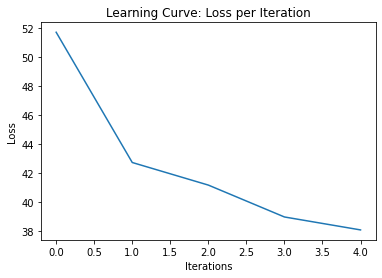

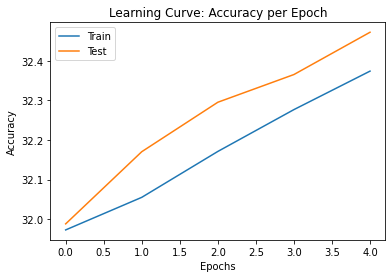

In [ ]:
DEBUG = False
DEBUG_NN = False

model_1 = train_model(stl10_train_split, stl10_test_split, enc_in_chnl=3, numb_classes=10, batch_size=10, num_epochs=5, image_shape=(3, 96, 96), dataset='STL10')
#model_1 = train_model(stl10_train_split, stl10_test_split, 3, 10, 10, 5, (3, 96, 96), 'STL10')


### STL10 CNN Training


CNN: in_channels: 3, num_hiddens: 32, numb_classes: 10, input_shape: (3, 96, 96)
Epoch 0, Train Iter 50, train_loss: 51.6997, train_acc: 31.9294, test_acc: 32.0342
Epoch 1, Train Iter 100, train_loss: 42.6853, train_acc: 32.0548, test_acc: 32.1262
Epoch 2, Train Iter 150, train_loss: 41.2411, train_acc: 32.1699, test_acc: 32.2941
Epoch 3, Train Iter 200, train_loss: 39.0416, train_acc: 32.2761, test_acc: 32.3646
Epoch 4, Train Iter 250, train_loss: 38.0328, train_acc: 32.3745, test_acc: 32.5150
Epoch 5, Train Iter 300, train_loss: 37.3139, train_acc: 32.5097, test_acc: 32.5715
Epoch 6, Train Iter 350, train_loss: 36.8388, train_acc: 32.5956, test_acc: 32.7102
Epoch 7, Train Iter 400, train_loss: 36.1262, train_acc: 32.6329, test_acc: 32.7533
Epoch 8, Train Iter 450, train_loss: 36.4126, train_acc: 32.7556, test_acc: 32.8387
Epoch 9, Train Iter 500, train_loss: 35.2751, train_acc: 32.8303, test_acc: 32.9204
Epoch 10, Train Iter 550, train_loss: 35.9163, train_acc: 32.8999, test_acc: 33.

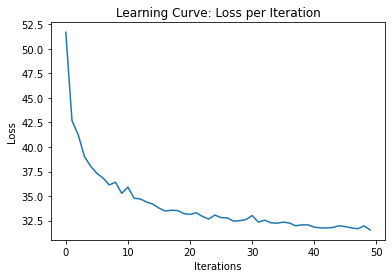

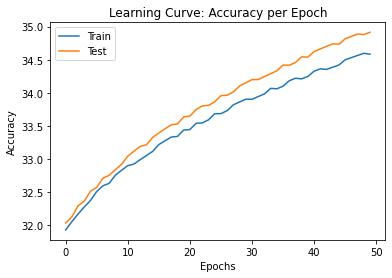

In [ ]:
model_1_stl10 = train_model(stl10_train_split, stl10_test_split, enc_in_chnl=3, numb_classes=10, batch_size=100, num_epochs=50, image_shape=(3, 96, 96), dataset='STL10')


## Train MNIST CNN

### MNIST Toy CNN Training


CNN: in_channels: 1, num_hiddens: 32, numb_classes: 10, input_shape: (1, 32, 32)
Epoch 0, Train Iter 6000, train_loss: 35.7113, train_acc: 51.9149, test_acc: 51.9765
Epoch 1, Train Iter 12000, train_loss: 26.6994, train_acc: 52.0427, test_acc: 52.1132
Epoch 2, Train Iter 18000, train_loss: 25.2239, train_acc: 52.2283, test_acc: 52.3083
Epoch 3, Train Iter 24000, train_loss: 23.0301, train_acc: 52.2627, test_acc: 52.3521
Epoch 4, Train Iter 30000, train_loss: 22.0829, train_acc: 52.4323, test_acc: 52.5281


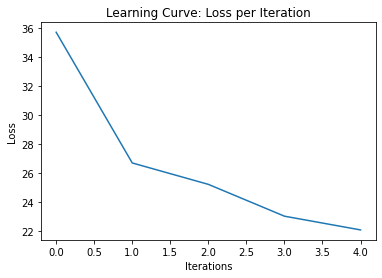

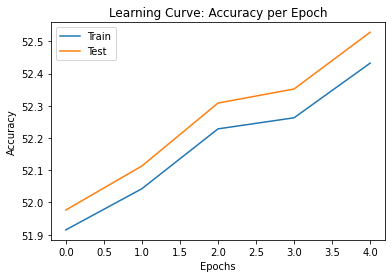

In [ ]:
DEBUG = False
DEBUG_NN = False

model_2 = train_model(mnist_train_split, mnist_test_split, enc_in_chnl=1, numb_classes=10, batch_size=10, num_epochs=5, image_shape=(1, 32, 32), dataset='Mnist')


### MNIST CNN Training

CNN: in_channels: 1, num_hiddens: 32, numb_classes: 10, input_shape: (1, 32, 32)
Epoch 0, Train Iter 120, train_loss: 35.7367, train_acc: 51.9873, test_acc: 52.0476
Epoch 1, Train Iter 240, train_loss: 26.7007, train_acc: 52.1133, test_acc: 52.1838
Epoch 2, Train Iter 360, train_loss: 25.2313, train_acc: 52.2271, test_acc: 52.2371
Epoch 3, Train Iter 480, train_loss: 23.0325, train_acc: 52.3340, test_acc: 52.3517
Epoch 4, Train Iter 600, train_loss: 22.0879, train_acc: 52.4306, test_acc: 52.5283
Epoch 5, Train Iter 720, train_loss: 21.3006, train_acc: 52.5238, test_acc: 52.6282
Epoch 6, Train Iter 840, train_loss: 20.8936, train_acc: 52.6088, test_acc: 52.7237
Epoch 7, Train Iter 960, train_loss: 20.0913, train_acc: 52.6201, test_acc: 52.8118
Epoch 8, Train Iter 1080, train_loss: 20.4240, train_acc: 52.6969, test_acc: 52.8252
Epoch 9, Train Iter 1200, train_loss: 19.2829, train_acc: 52.8423, test_acc: 52.9792
Epoch 10, Train Iter 1320, train_loss: 19.9054, train_acc: 52.8437, test_acc:

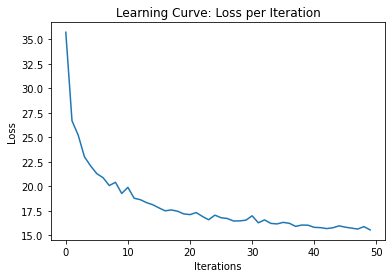

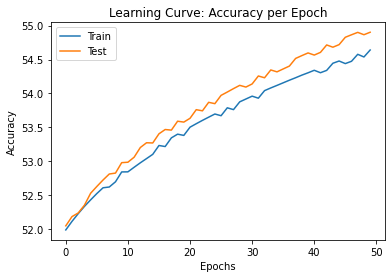

In [ ]:
DEBUG = False
DEBUG_NN = False

model_2_mnist = train_model(mnist_train_split, mnist_test_split, enc_in_chnl=1, numb_classes=10, batch_size=500, num_epochs=50, image_shape=(1, 32, 32), dataset='Mnist')


### Save Trained CNN Models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Save models in GDrive for future use
model_path_stl10_beta = model_path_stl10.split('.')[0] + '_sup_stl10' + '.pk'
model_path_mnist_beta = model_path_mnist.split('.')[0] + '_sup_mnist' + '.pk'

if (model_path_stl10 is not None):
    torch.save(model_1_stl10_cnn.state_dict(), model_path_stl10_beta)
if (model_path_mnist is not None):
    torch.save(model_2_mnist_cnn.state_dict(), model_path_mnist_beta)


# Experiments



### Load Models from GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#VAE Class inputs: 
enc_in_chnl = 3
enc_in_chnl_mnist = 1
enc_num_hidden = 32
dec_in_chnl = 32
dec_num_hidden = 256
latent = 200
image_shape_stl10 = (3, 96, 96)
image_shape_mnist = (1, 32, 32)

model_2_stl10 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent, input_shape=image_shape_stl10)
#model_2_stl10.to(dev)
model_2_mnist = VAE(enc_in_chnl_mnist, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent, input_shape=image_shape_mnist)
#model_2_mnist.to(dev)
# Load trained models from GDrive
print(f'dev: {dev}')
if (model_path_stl10 is not None):
    model_2_stl10.load_state_dict(torch.load(model_path_stl10, map_location=torch.device(dev)))
if (model_path_mnist is not None):
    model_2_mnist.load_state_dict(torch.load(model_path_mnist, map_location=torch.device(dev)))

model_2_stl10.eval()
model_2_mnist.eval()
#print(model_2_stl10)
#print(model_2_mnist)


Mounted at /content/gdrive
Encoder: in_channels: 3, num_hiddens: 32, latent: 200, input_shape: (3, 96, 96)
fc1_inp: 9216
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (3, 96, 96)
Encoder: in_channels: 1, num_hiddens: 32, latent: 200, input_shape: (1, 32, 32)
fc1_inp: 1024
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (1, 32, 32)
dev: cuda


VAE(
  (encode): Encoder(
    (block1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (relu): ReLU()
    (fc_mu): Linear(in_features

### Classify Images

In [ ]:
# Classify images
def classify_images(model_2, training_data, labels_test_split, dataset_type, N, numb_classes):
  # Reshape the latent
  # Latent dimension = as in trained model
  in_features = 200
  # stl10_class_names
  fc2 = torch.nn.Linear(in_features=in_features, out_features=numb_classes)
  logsoftmax = torch.nn.LogSoftmax(dim=1)
  #print(f'stl10_class_names: {stl10_class_names}')

  correct = 0
  for i in range(N):
    # Calculate image latent
    img1, latent1, img_idx1 = get_img_latent(model_2, training_data, dataset_type, False)
    latent1 = fc2(latent1.to('cpu'))
    zs = logsoftmax(latent1)
    #print(f'log_softmax zs.shape: {zs.shape}')
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.to('cpu').detach().numpy()[0,0]
    # compare img label vs predicted label
#    print(f'predicted label: {pred}, predicted image class: {stl10_class_names[pred]}')
#    print(f'label: {labels_test_split[img_idx1]}, image class: {stl10_class_names[labels_test_split[img_idx1]]}')
    if DEBUG:
      print(f'predicted label: {pred}, label: {labels_test_split[img_idx1]}')
    correct += (pred == labels_test_split[img_idx1]).sum()

  return correct / N

# Classify STL10 images
print('Classify STL10 images')
# As number of images classes
numb_classes = len(stl10_class_names)
pred = classify_images(model_2_stl10.to(dev), stl10_test_split, stl10_labels_test_split, 'stl10', 5, numb_classes)
print(f'percentage of correctly classified images: {pred:.4f}')


# Classify MNIST images
print('Classify MNIST images:')
# As number of images classes
numb_classes = 10
pred = classify_images(model_2_mnist.to(dev), mnist_test_split.data, mnist_test_split.targets, 'mnist', 20, numb_classes)
print(f'percentage of correctly classified images: {pred:.4f}')


Classify STL10 images
percentage of correctly classified images: 0.4000
Classify MNIST images:
percentage of correctly classified images: 0.5500


In [ ]:
def show(imgs):
    # your code goes here:
  plt.figure(figsize=(8, 4))
  for i, item in enumerate(imgs):
      if i >= 32:
#        print('indexes error')
        break
      plt.subplot(4, 8, i+1)
#      img = item.numpy().transpose((1, 2, 0))
      plt.imshow(item)
#      plt.imshow(item[0].squeeze().numpy())

  return None

def show_random_images(imgs_nparray, N):
  xs = []
  for i in range(N):
    sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
    img = imgs_nparray[sample_idx]
    xs.append(img)
  show(xs)


# Automatic PDF Generation and store in GDrive

In [1]:
notebook_name= 'IDL_Project_v1'

!apt-get install texlive texlive-xetex texlive-latex-extra pandoc > /dev/null 2>&1
!pip install pypandoc > /dev/null 2>&1
from google.colab import drive
drive.mount('/content/drive')
!cp 'drive/My Drive/Colab Notebooks/'$notebook_name'.ipynb' ./

!jupyter nbconvert --to PDF $notebook_name'.ipynb' > /dev/null 2>&1
!echo "pdf file generated"
!ls -la
!cp './'$notebook_name'.pdf' 'drive/My Drive/Colab Notebooks'

Mounted at /content/drive
pdf file generated
total 4600
drwxr-xr-x 1 root root    4096 Feb 15 00:01 .
drwxr-xr-x 1 root root    4096 Feb 14 23:55 ..
drwxr-xr-x 4 root root    4096 Feb 13 14:34 .config
drwx------ 5 root root    4096 Feb 15 00:00 drive
-rw------- 1 root root 2726222 Feb 15 00:00 IDL_Project_v1.ipynb
-rw-r--r-- 1 root root 1960775 Feb 15 00:01 IDL_Project_v1.pdf
drwxr-xr-x 1 root root    4096 Feb 13 14:35 sample_data
